In [ ]:
import pandas as pd
import numpy


First, we read the data from a file and create a dataframe from it, where each row indicates which category a question belongs to, as identified by labels 1 to 5. This is for an NLP project.

In [ ]:
from sklearn.model_selection import KFold
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
labels= [1, 2, 3, 4, 5]

In [ ]:
from parsivar import Normalizer
my_normalizer = Normalizer(statistical_space_correction=True,pinglish_conversion_needed=True)  ## نرمالایز کردن
#train['query']=train['query'].apply(lambda s:my_normalizer.normalize(s))
#test['query']=test['query'].apply(lambda s:my_normalizer.normalize(s))

headers= ['query', 'label']
data = [train["query"], train["label"]]
training_data = pd.concat(data, axis=1, keys=headers)
training_data =training_data.drop_duplicates(subset = headers ,keep='last' ).reset_index(drop=True)  ##حذف پرسش های تکراری
ready_algo_train_df= pd.DataFrame(columns=['query' , 'label'])   ## ساختن دیتافریمی برای الگوریتم های آماده
ready_algo_test_df= pd.DataFrame(columns=['query' ])          ## ساختن دیتافریمی برای الگوریتم های آماده
display(training_data)
display(test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Next, we normalize, stem, and tokenize the words using a library. We also remove extra characters from the tokens and eliminate duplicate sentences. In the following step, the 'counting_words' function is used to determine the frequency of each word in labels 1 to 5, and we store this information in a dataframe. Additionally, we calculate how many words exist in each category, as this will be useful for calculating probabilities later on.

In [ ]:
from __future__ import unicode_literals
from hazm import *

all_words_df = pd.DataFrame({'numberOFWord':[0,0,0,0,0]}, index =[1, 2,3,4,5])
stemmer = Stemmer()

def stem(w):      ## گرفتن ریشه کلمات
    return stemmer.stem(w)

def remove_stop_words(words):  ## حذف حروف اضاقه از کلمات
    new_words=[]
    for w in words:
        if(len(w) >2):
            new_words.append(w)
    return new_words
def counting_words(ready_algo_train_df):    ##  توکنایز کردن جملات و شمارش کلمه ها
    for row in training_data.itertuples():
        query = row.query
        label = row.label
        words = word_tokenize(query)
        #words = list(map(stem, words))
        words = remove_stop_words(words)
        new_row = {'query': str(words), 'label': label}
        ready_algo_train_df = ready_algo_train_df.append(new_row, ignore_index = True)
        for w in words:
            if w not in all_words_df.columns:
                all_words_df[w] = [0,0,0,0,0]
            all_words_df.loc[label][w]+=1
            all_words_df.loc[label]['numberOFWord'] +=1
    display(all_words_df)
    return all_words_df , ready_algo_train_df

In the next step, we calculate the probability of the presence of each word in each category.

In [ ]:

def calculate_words_prob(all_words_df):  ## محاسبه احتمال وجود هر کلمه در هر دسته بندی
    columns = all_words_df.columns
    prob_of_words_df = pd.DataFrame(columns = all_words_df.columns , index =[1, 2,3,4,5])
    del prob_of_words_df['numberOFWord']
    V = len(prob_of_words_df.columns)
    for w in prob_of_words_df.columns:
        #print("here")
        for label in labels:
            count_w_c=  all_words_df.loc[label][w]
            count_c = all_words_df.loc[label]['numberOFWord']
            prob = (count_w_c + 1)/(count_c + V)
            prob_of_words_df.loc[label][w] = prob
            #print(prob)
    display(prob_of_words_df)
    return prob_of_words_df


Now, we need to calculate, based on the Naive Bayes algorithm, the probability of each sentence belonging to a particular category for our test data. First, like our training data, we tokenize it.

For each sentence, we calculate the product of the probabilities of each word's presence in each label. Finally, the sentence is assigned to the category that had the highest probability.

In [ ]:
def probability_of_words_in_a_class(label , words, prob_of_words_df):  ## احتمال وجود جمله در دسته خاص
    prob=1
    V = len(prob_of_words_df.columns)
    for w in words:
        if(w in prob_of_words_df.columns):
            prob *= prob_of_words_df.loc[label][w]
        else:
            prob *= ((0 +1 )/ (all_words_df.loc[label]['numberOFWord'] + V))
    return prob

result = []
def calculate_result(ready_algo_test_df ,prob_of_words_df):  ## محاسبه کردن دسته هر جمله
    for new_sentence in test['query']:
        words = word_tokenize(new_sentence)
        words = remove_stop_words(words)
        ready_algo_test_df = ready_algo_test_df.append({'query': str(words)}, ignore_index = True)
        best_answer=0
        best_label=0
        for i in labels:  ## پیداکردن لیبلی با بیشترین احتمال
            curr_prob = probability_of_words_in_a_class( i , words , prob_of_words_df)
            if(curr_prob > best_answer):
                best_answer = curr_prob
                best_label = i
        result.append(best_label)
    return ready_algo_test_df
    #print(best_label)

In [ ]:
def write_to_csv():
    result_headers= ['id', 'label']
    result_data = [test["id"], pd.Series(result)]
    result_df = pd.concat(result_data, axis=1, keys=result_headers)
    result_df.to_csv('out.csv', index=False)
    out= pd.read_csv("out.csv")
    display(out)
    return out

In [ ]:
all_words_df , ready_algo_train_df = counting_words(ready_algo_train_df)
prob_of_words_df= calculate_words_prob(all_words_df)
ready_algo_test_df = calculate_result(ready_algo_test_df , prob_of_words_df )
out = write_to_csv()

,numberOFWord,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,4447,48,9,6,0,0,1,57,0,0,...,0,0,0,0,0,0,1,1,0,0
2,2956,128,12,18,4,1,2,34,21,1,...,0,1,0,0,0,1,0,0,0,0
3,2470,15,4,1,0,0,0,46,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3525,1,0,1,0,2,2,0,13,0,...,0,0,1,0,0,0,0,0,0,0
5,2134,21,1,2,0,0,0,8,6,0,...,1,0,0,1,1,0,0,0,1,0


,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,ساعت,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,0.007024,0.001433,0.001003,0.000143,0.000143,0.000287,0.008314,0.000143,0.000143,0.000717,...,0.000143,0.000143,0.000143,0.000143,0.000143,0.000143,0.000287,0.000287,0.000143,0.000143
2,0.023519,0.00237,0.003464,0.000912,0.000365,0.000547,0.006381,0.004011,0.000365,0.005469,...,0.000182,0.000365,0.000182,0.000182,0.000182,0.000365,0.000182,0.000182,0.000182,0.000182
3,0.003201,0.001,0.0004,0.0002,0.0002,0.0002,0.009402,0.0002,0.0002,0.0022,...,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0004
4,0.00033,0.000165,0.00033,0.000165,0.000496,0.000496,0.000165,0.002313,0.000165,0.001652,...,0.000165,0.000165,0.00033,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165
5,0.004718,0.000429,0.000643,0.000214,0.000214,0.000214,0.00193,0.001501,0.000214,0.001501,...,0.000429,0.000214,0.000214,0.000429,0.000429,0.000214,0.000214,0.000214,0.000429,0.000214


,id,label
0,0,4
1,1,1
2,2,4
3,3,2
4,4,2
...,...,...
757,757,5
758,758,2
759,759,1
760,760,5


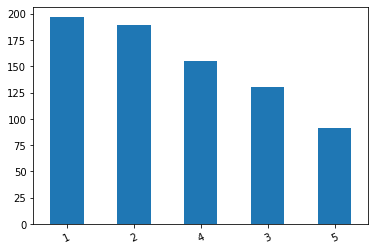

In [ ]:
import matplotlib.pyplot as plt
s=out['label'].value_counts()
threshold = 0.02
mask = s > threshold
tail_prob = s.loc[~mask].sum()
s = s.loc[mask]
s.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

In [ ]:
from sklearn import  svm
def svm_algorithm(Train_X ,y_train , Test_X):  ## الگوریتم آماده SVM
    SVM = svm.SVC( C=1.0, kernel='linear', gamma='auto', degree=3)
    SVM.fit(Train_X,y_train.astype('int'))
    prediction = SVM.predict(Test_X)
    svm_algo_result = pd.DataFrame({'id':range(0,len(prediction)), 'label': prediction})
    svm_algo_result.to_csv('svm_algo_result.csv', index=False)
    return prediction

In [ ]:
from sklearn import naive_bayes
def multi_naive_bayes_algorithm(Train_X ,y_train , Test_X):  ##  الگوریتم آماده multi naive bayes
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Train_X,y_train.astype('int'))
    prediction = Naive.predict(Test_X)
    multi_nb_algo_result = pd.DataFrame({'id':range(0,len(prediction)), 'label': prediction})
    multi_nb_algo_result.to_csv('multi_nb_algo_result.csv', index=False)
    return prediction

In [ ]:
from sklearn.metrics import  precision_score , recall_score, classification_report, confusion_matrix , accuracy_score, f1_score

criteria_data = {'Accuracies':[[],[],[]],'Recalls':[[],[],[]], 'f1-scores':[[],[],[]]}  ## ساختن دیتا فریمی برای معیار های سنجش
criteria_df = pd.DataFrame(criteria_data, index =['Naive-bayes', 'Multi-naive-bayes', 'SVM'])

def criteria_result(y_test ,predictions , algo_name):  ## محاسبه معیار ها برای هر الگوریتم و پیش بینی
    acc_score = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions , average='weighted')
    f1_s = f1_score(y_test, predictions ,average='weighted')
    criteria_df.loc[algo_name]['Accuracies'].append(round(acc_score, 5))
    criteria_df.loc[algo_name]['Recalls'].append(round(recall, 5))
    criteria_df.loc[algo_name]['f1-scores'].append(round(f1_s, 5))

In [ ]:
from sklearn import model_selection
import ast
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
kfold = KFold(n_splits=3)
X = ready_algo_train_df['query']
y = ready_algo_train_df['label']
X_list= X.apply(lambda x: ast.literal_eval(x))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_list, y, random_state=1)
kfold.get_n_splits(X_train)
words = ready_algo_train_df['query'].apply(lambda x: ast.literal_eval(x)).sum()
for train_i, test_i in kfold.split(X):
    X_train, X_test = X[train_i], X[test_i]
    y_train, y_test = y[train_i], y[test_i]
    Tfidf_vect = TfidfVectorizer(max_features=10000)
    Tfidf_vect.fit(words)
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    y_test =y_test.astype('int')
    ##### svm ######
    prediction = svm_algorithm(Train_X_Tfidf ,y_train,Test_X_Tfidf)
    criteria_result(y_test , prediction , 'SVM')

    ##### multi naive bayes ######
    prediction = multi_naive_bayes_algorithm(Train_X_Tfidf ,y_train,Test_X_Tfidf)
    criteria_result(y_test , prediction , 'Multi-naive-bayes')



In [ ]:
criteria_df

,Accuracies,Recalls,f1-scores
Naive-bayes,[],[],[]
Multi-naive-bayes,"[0.72354, 0.68654, 0.75951]","[0.72354, 0.68654, 0.75951]","[0.69944, 0.66862, 0.73897]"
SVM,"[0.7739, 0.76156, 0.7852]","[0.7739, 0.76156, 0.7852]","[0.7725, 0.76113, 0.78625]"


In [ ]:
from sklearn.model_selection import KFold
from sklearn import model_selection
kfold = KFold(n_splits=3)
new_x_train=training_data['query']
new_y=training_data['label']
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_x_train,new_y , random_state=1)

for train_i, test_i in kfold.split(new_x_train):
    result = []
    X_train, X_test = new_x_train[train_i], new_x_train[test_i]
    y_train, y_test = new_y[train_i], new_y[test_i]
    training_data = pd.DataFrame()
    training_data['query'] = X_train.dropna()
    training_data['label'] = y_train.dropna()
    test = pd.DataFrame()
    test['query'] = X_test.dropna()
    test['label'] = y_test.dropna()
    all_words_df , ready_algo_train_df = counting_words(ready_algo_train_df)
    prob_of_words_df= calculate_words_prob(all_words_df)
    ready_algo_test_df = calculate_result(ready_algo_test_df , prob_of_words_df )
    criteria_result(test['label'] , result , 'Naive-bayes')

,numberOFWord,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,7444,83,17,12,0,0,2,98,0,0,...,0,0,0,0,0,0,2,2,0,0
2,4905,201,19,30,7,1,2,56,36,1,...,0,2,0,0,0,2,0,0,0,0
3,4143,22,5,2,0,0,0,76,0,0,...,0,0,0,0,0,0,0,0,0,2
4,5805,2,0,2,0,3,3,0,19,0,...,0,0,2,0,0,0,0,0,0,0
5,3544,35,1,4,0,0,0,13,9,0,...,2,0,0,2,2,0,0,0,2,0


,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,ساعت,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,0.008423,0.001805,0.001304,0.0001,0.0001,0.000301,0.009927,0.0001,0.0001,0.000702,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.000301,0.000301,0.0001,0.0001
2,0.027172,0.00269,0.00417,0.001076,0.000269,0.000404,0.007667,0.004977,0.000269,0.006995,...,0.000135,0.000404,0.000135,0.000135,0.000135,0.000404,0.000135,0.000135,0.000135,0.000135
3,0.003447,0.000899,0.00045,0.00015,0.00015,0.00015,0.011541,0.00015,0.00015,0.002848,...,0.00015,0.00015,0.00015,0.00015,0.00015,0.00015,0.00015,0.00015,0.00015,0.00045
4,0.00036,0.00012,0.00036,0.00012,0.00048,0.00048,0.00012,0.0024,0.00012,0.0018,...,0.00012,0.00012,0.00036,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012
5,0.005928,0.000329,0.000823,0.000165,0.000165,0.000165,0.002305,0.001647,0.000165,0.002141,...,0.000494,0.000165,0.000165,0.000494,0.000494,0.000165,0.000165,0.000165,0.000494,0.000165


,numberOFWord,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,10478,113,21,16,0,0,2,141,0,0,...,0,0,0,0,0,0,3,3,0,0
2,6873,295,29,44,10,2,4,82,51,2,...,0,3,0,0,0,3,0,0,0,0
3,5782,33,9,2,0,0,0,110,0,0,...,0,0,0,0,0,0,0,0,0,3
4,8180,3,0,3,0,4,5,0,29,0,...,0,0,3,0,0,0,0,0,0,0
5,4927,50,2,6,0,0,0,18,13,0,...,3,0,0,3,3,0,0,0,3,0


,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,ساعت,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,0.008765,0.001691,0.001307,0.000077,0.000077,0.000231,0.010917,0.000077,0.000077,0.000846,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000308,0.000308,0.000077,0.000077
2,0.031483,0.003191,0.004786,0.00117,0.000319,0.000532,0.008828,0.005531,0.000319,0.007339,...,0.000106,0.000425,0.000106,0.000106,0.000106,0.000425,0.000106,0.000106,0.000106,0.000106
3,0.004091,0.001203,0.000361,0.00012,0.00012,0.00012,0.013356,0.00012,0.00012,0.002767,...,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012,0.00012,0.000481
4,0.000374,0.000093,0.000374,0.000093,0.000467,0.00056,0.000093,0.002801,0.000093,0.001961,...,0.000093,0.000093,0.000374,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093
5,0.00684,0.000402,0.000939,0.000134,0.000134,0.000134,0.002548,0.001878,0.000134,0.002012,...,0.000536,0.000134,0.000134,0.000536,0.000536,0.000134,0.000134,0.000134,0.000536,0.000134


,numberOFWord,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,13341,144,27,18,0,0,3,171,0,0,...,0,0,0,0,0,0,3,3,0,0
2,8868,384,36,54,12,3,6,102,63,3,...,0,3,0,0,0,3,0,0,0,0
3,7410,45,12,3,0,0,0,138,0,0,...,0,0,0,0,0,0,0,0,0,3
4,10575,3,0,3,0,6,6,0,39,0,...,0,0,3,0,0,0,0,0,0,0
5,6402,63,3,6,0,0,0,24,18,0,...,3,0,0,3,3,0,0,0,3,0


,کجا,تونم,دکتر,وحیدی,ارتباط,برقرار,کنم,بوفه,برداران,ساعت,...,حائری,برمیگردن,خودشان,ولنجک,پاسداران,IoT,میچینه,منع,استقلال,ارکد
1,0.009137,0.001764,0.001197,0.000063,0.000063,0.000252,0.010838,0.000063,0.000063,0.000819,...,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000252,0.000252,0.000063,0.000063
2,0.033781,0.003246,0.004826,0.001141,0.000351,0.000614,0.009037,0.005616,0.000351,0.007721,...,0.000088,0.000351,0.000088,0.000088,0.000088,0.000351,0.000088,0.000088,0.000088,0.000088
3,0.004628,0.001308,0.000402,0.000101,0.000101,0.000101,0.013985,0.000101,0.000101,0.003119,...,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000402
4,0.000305,0.000076,0.000305,0.000076,0.000534,0.000534,0.000076,0.003053,0.000076,0.002137,...,0.000076,0.000076,0.000305,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
5,0.007166,0.000448,0.000784,0.000112,0.000112,0.000112,0.002799,0.002127,0.000112,0.002127,...,0.000448,0.000112,0.000112,0.000448,0.000448,0.000112,0.000112,0.000112,0.000448,0.000112


In [ ]:
criteria_df

,Accuracies,Recalls,f1-scores
Naive-bayes,"[0.86948, 0.89106, 0.92395]","[0.86948, 0.89106, 0.92395]","[0.86815, 0.89096, 0.92378]"
Multi-naive-bayes,"[0.72354, 0.68654, 0.75951]","[0.72354, 0.68654, 0.75951]","[0.69944, 0.66862, 0.73897]"
SVM,"[0.7739, 0.76156, 0.7852]","[0.7739, 0.76156, 0.7852]","[0.7725, 0.76113, 0.78625]"


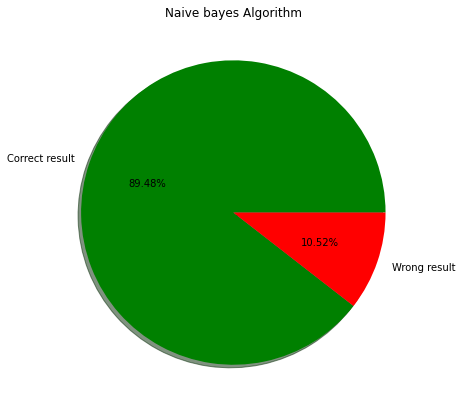

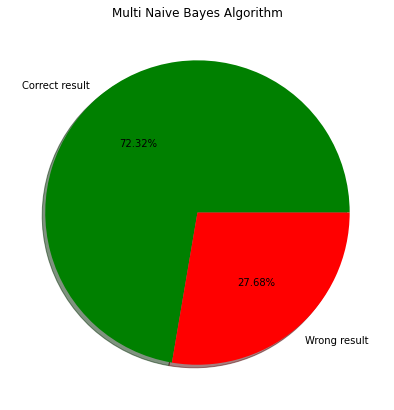

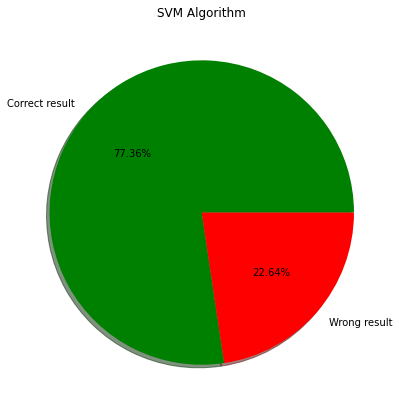

In [ ]:
from matplotlib import pyplot as plt
multi_nb_acc_avg= sum(criteria_df.loc['Multi-naive-bayes']['Accuracies'])/3
svm_acc_avg= sum(criteria_df.loc['SVM']['Accuracies'])/3
Naive_bayes_acc_avg= sum(criteria_df.loc['Naive-bayes']['Accuracies'])/3

colors = ( "green", "red")
results = ['Correct result', 'Wrong result']

multi_nb_data = [multi_nb_acc_avg , 1 - multi_nb_acc_avg]
svm_data = [svm_acc_avg , 1 - svm_acc_avg]
Naive_bayes_data = [Naive_bayes_acc_avg , 1 - Naive_bayes_acc_avg]

# Creating plot
fig3 = plt.figure(figsize =(10, 7))
plt.pie(Naive_bayes_data, labels = results,colors = colors,shadow = True, autopct='%1.2f%%')
plt.title("Naive bayes Algorithm")

fig = plt.figure(figsize =(10, 7))
plt.pie(multi_nb_data, labels = results,colors = colors,shadow = True, autopct='%1.2f%%')
plt.title("Multi Naive Bayes Algorithm")

fig2 = plt.figure(figsize =(10, 7))
plt.pie(svm_data, labels = results,colors = colors,shadow = True, autopct='%1.2f%%')
plt.title("SVM Algorithm")


# show plot
plt.show()